In [1]:
# Baseline CNN Model for Ankle Alignment Classification
# This notebook loads processed images and trains a simple CNN as a baseline

import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


## 1. Configuration

Define paths and parameters for loading data.


In [2]:
# Paths
DATA_DIR = Path("../data/processed")
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR = DATA_DIR / "val"
TEST_DIR = DATA_DIR / "test"
MODEL_DIR = Path("../models")

# Check if processed data exists
if not DATA_DIR.exists():
    raise FileNotFoundError(
        f"Processed data not found at {DATA_DIR}. "
        "Please run 'python src/01-data-preprocessing.py' first."
    )

if not MODEL_DIR.exists():
    MODEL_DIR.mkdir(parents=True)

# Image parameters
IMAGE_SIZE = 224  # Expected image size
NUM_CHANNELS = 3  # RGB images

# Label mapping
LABEL_TO_IDX = {
    'Pronation': 0,
    'Neutral': 1,
    'Supination': 2
}
IDX_TO_LABEL = {v: k for k, v in LABEL_TO_IDX.items()}
NUM_CLASSES = len(LABEL_TO_IDX)

print(f"Data directory: {DATA_DIR.absolute()}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Labels: {list(LABEL_TO_IDX.keys())}")


Data directory: d:\src\repos\ankle-align\notebook\..\data\processed
Number of classes: 3
Labels: ['Pronation', 'Neutral', 'Supination']


## 2. Load Data into NumPy Arrays

Load all images and labels into X and y arrays for train, validation, and test sets.


In [3]:
def load_images_from_directory(base_dir: Path, label_to_idx: dict) -> tuple:
    """
    Load all images from a directory organized by label subdirectories.
    
    Args:
        base_dir: Path to directory containing label subdirectories
        label_to_idx: Dictionary mapping label names to indices
        
    Returns:
        X: numpy array of shape (N, H, W, C) with pixel values in [0, 1]
        y: numpy array of shape (N,) with label indices
    """
    images = []
    labels = []
    
    for label_name, label_idx in label_to_idx.items():
        label_dir = base_dir / label_name
        if not label_dir.exists():
            print(f"Warning: Directory {label_dir} not found")
            continue
            
        image_files = list(label_dir.glob("*.png"))
        print(f"  {label_name}: {len(image_files)} images")
        
        for img_path in image_files:
            try:
                # Load image and convert to RGB
                img = Image.open(img_path).convert('RGB')
                # Convert to numpy array and normalize to [0, 1]
                img_array = np.array(img, dtype=np.float32) / 255.0
                images.append(img_array)
                labels.append(label_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                continue
    
    X = np.array(images)
    y = np.array(labels)
    
    return X, y


In [4]:
# Load training data
print("Loading training data...")
X_train, y_train = load_images_from_directory(TRAIN_DIR, LABEL_TO_IDX)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

# Load validation data
print("\nLoading validation data...")
X_val, y_val = load_images_from_directory(VAL_DIR, LABEL_TO_IDX)
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

# Load test data
print("\nLoading test data...")
X_test, y_test = load_images_from_directory(TEST_DIR, LABEL_TO_IDX)
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Loading training data...
  Pronation: 87 images
  Neutral: 95 images
  Supination: 34 images
X_train shape: (216, 224, 224, 3), y_train shape: (216,)

Loading validation data...
  Pronation: 19 images
  Neutral: 21 images
  Supination: 7 images
X_val shape: (47, 224, 224, 3), y_val shape: (47,)

Loading test data...
  Pronation: 19 images
  Neutral: 21 images
  Supination: 7 images
X_test shape: (47, 224, 224, 3), y_test shape: (47,)


In [5]:
# Print summary
print("\n" + "=" * 50)
print("DATA SUMMARY")
print("=" * 50)
print(f"\nTotal samples: {len(X_train) + len(X_val) + len(X_test)}")
print(f"  Training:   {len(X_train)} samples")
print(f"  Validation: {len(X_val)} samples")
print(f"  Test:       {len(X_test)} samples")

print(f"\nImage shape: {X_train.shape[1:]} (H x W x C)")
print(f"Pixel value range: [{X_train.min():.3f}, {X_train.max():.3f}]")

print("\nLabel distribution:")
for split_name, y in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    print(f"\n  {split_name}:")
    for idx, label in IDX_TO_LABEL.items():
        count = np.sum(y == idx)
        pct = count / len(y) * 100
        print(f"    {label}: {count} ({pct:.1f}%)")



DATA SUMMARY

Total samples: 310
  Training:   216 samples
  Validation: 47 samples
  Test:       47 samples

Image shape: (224, 224, 3) (H x W x C)
Pixel value range: [0.000, 1.000]

Label distribution:

  Train:
    Pronation: 87 (40.3%)
    Neutral: 95 (44.0%)
    Supination: 34 (15.7%)

  Val:
    Pronation: 19 (40.4%)
    Neutral: 21 (44.7%)
    Supination: 7 (14.9%)

  Test:
    Pronation: 19 (40.4%)
    Neutral: 21 (44.7%)
    Supination: 7 (14.9%)


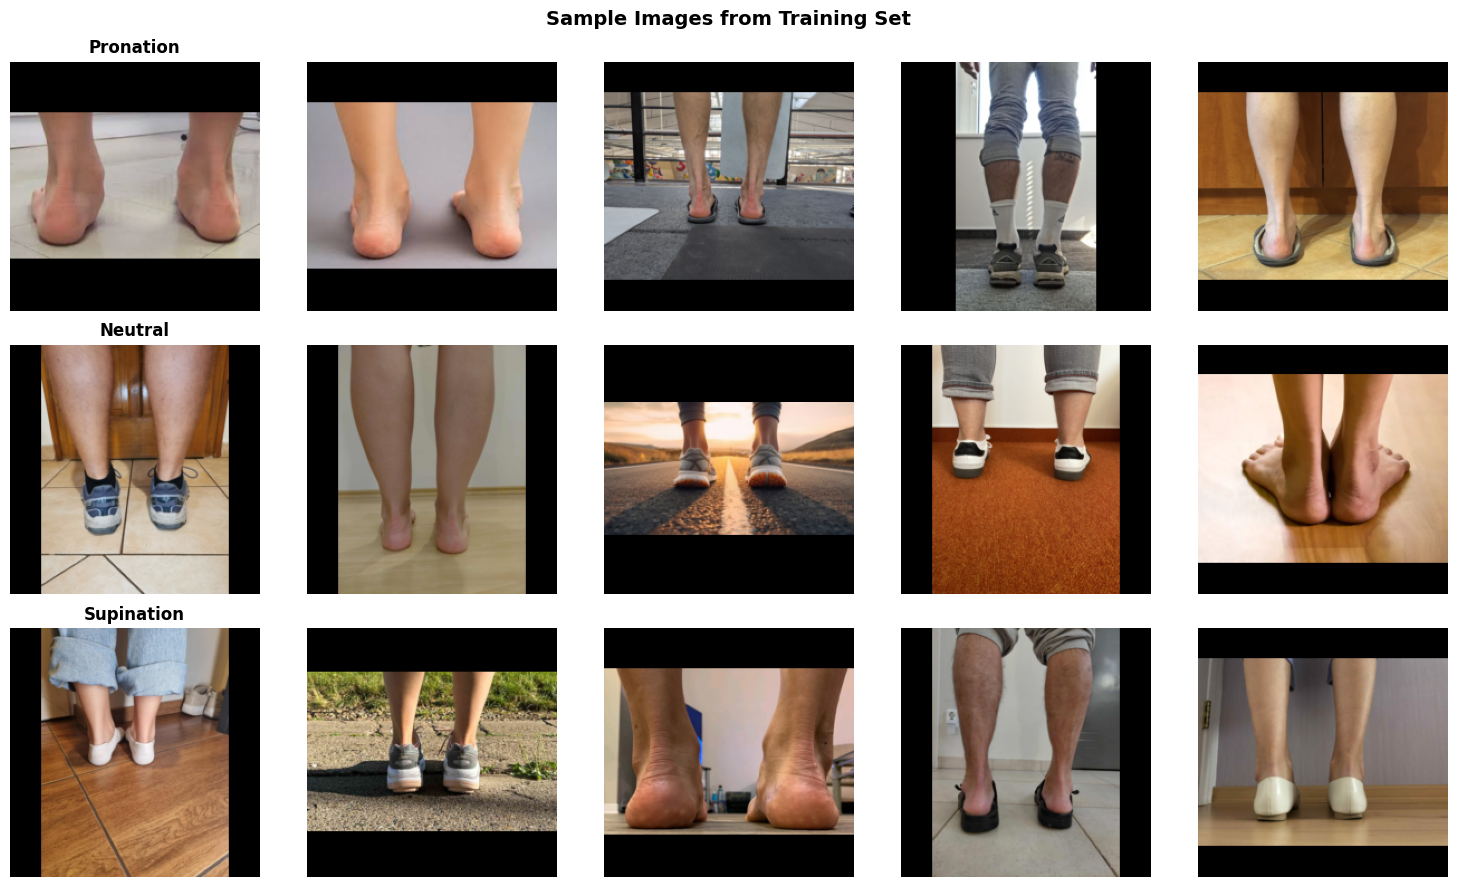

In [6]:
# Visualize sample images from each class
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle('Sample Images from Training Set', fontsize=14, fontweight='bold')

for class_idx in range(NUM_CLASSES):
    class_indices = np.where(y_train == class_idx)[0]
    sample_indices = np.random.choice(class_indices, min(5, len(class_indices)), replace=False)
    
    for i, idx in enumerate(sample_indices):
        ax = axes[class_idx, i]
        ax.imshow(X_train[idx])
        ax.axis('off')
        if i == 0:
            ax.set_title(f"{IDX_TO_LABEL[class_idx]}", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


## 3. Prepare Data for PyTorch

Convert numpy arrays to PyTorch tensors and create DataLoaders.


In [7]:
# Convert to PyTorch tensors
# Note: PyTorch expects (N, C, H, W) format, so we transpose from (N, H, W, C)

def numpy_to_tensor(X, y):
    """Convert numpy arrays to PyTorch tensors."""
    # Transpose from (N, H, W, C) to (N, C, H, W)
    X_tensor = torch.from_numpy(X.transpose(0, 3, 1, 2)).float()
    y_tensor = torch.from_numpy(y).long()
    return X_tensor, y_tensor

X_train_t, y_train_t = numpy_to_tensor(X_train, y_train)
X_val_t, y_val_t = numpy_to_tensor(X_val, y_val)
X_test_t, y_test_t = numpy_to_tensor(X_test, y_test)

print(f"Tensor shapes:")
print(f"  X_train: {X_train_t.shape} (N, C, H, W)")
print(f"  y_train: {y_train_t.shape}")
print(f"  X_val:   {X_val_t.shape}")
print(f"  y_val:   {y_val_t.shape}")
print(f"  X_test:  {X_test_t.shape}")
print(f"  y_test:  {y_test_t.shape}")


Tensor shapes:
  X_train: torch.Size([216, 3, 224, 224]) (N, C, H, W)
  y_train: torch.Size([216])
  X_val:   torch.Size([47, 3, 224, 224])
  y_val:   torch.Size([47])
  X_test:  torch.Size([47, 3, 224, 224])
  y_test:  torch.Size([47])


In [8]:
# Create DataLoaders
BATCH_SIZE = 32

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoader batch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


DataLoader batch size: 32
Training batches: 7
Validation batches: 2
Test batches: 2


## 4. Define Simple Baseline CNN

A very simple CNN architecture for baseline comparison:
- 3 convolutional blocks with max pooling
- Global average pooling
- Single fully connected layer for classification


In [9]:
class SimpleTinyCNN(nn.Module):
    """
    A very small CNN (<5k parameters) for ankle alignment classification.
    
    Architecture:
    - Conv Block 1: Conv2d(3, 8) -> BatchNorm -> ReLU -> MaxPool
    - Conv Block 2: Conv2d(8, 16) -> BatchNorm -> ReLU -> MaxPool
    - Global Average Pooling
    - Fully Connected -> 3 classes
    """
    def __init__(self, num_classes=3):
        super(SimpleTinyCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 224 -> 112
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 112 -> 56
        )
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(16, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Update model class name usage
SimpleBaselineCNN = SimpleTinyCNN

# Create model
model = SimpleBaselineCNN(num_classes=NUM_CLASSES)
model = model.to(device)

# Print model summary
print("MODEL ARCHITECTURE")
print("=" * 50)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


MODEL ARCHITECTURE
SimpleTinyCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=16, out_features=3, bias=True)
)

Total parameters: 1,491
Trainable parameters: 1,491


In [10]:
# Test forward pass
sample_input = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE).to(device)
sample_output = model(sample_input)
print(f"\nForward pass test:")
print(f"  Input shape: {sample_input.shape}")
print(f"  Output shape: {sample_output.shape}")
print(f"  Output: {sample_output.detach().cpu().numpy()}")



Forward pass test:
  Input shape: torch.Size([1, 3, 224, 224])
  Output shape: torch.Size([1, 3])
  Output: [[-0.9499357  -0.31001455  0.31672215]]


## 5. Training Setup

Define loss function, optimizer, and training/evaluation functions.


In [11]:
# Training configuration
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
EARLY_STOPPING_PATIENCE = 20

# Loss function (with class weights to handle imbalance)
class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * NUM_CLASSES  # Normalize
class_weights = torch.FloatTensor(class_weights).to(device)

print("Class weights (to handle imbalance):")
for idx, label in IDX_TO_LABEL.items():
    print(f"  {label}: {class_weights[idx]:.3f}")

criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


Class weights (to handle imbalance):
  Pronation: 0.670
  Neutral: 0.614
  Supination: 1.716


In [12]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    """Evaluate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels)


## 6. Train the Model


In [13]:
# Training loop
print("TRAINING")
print("=" * 50)

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_loss = float('inf')
best_val_acc = 0.0
patience_counter = 0
best_model_state = None
EARLY_STOPPING = False # experimenting

for epoch in range(NUM_EPOCHS):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print progress
    print(f"Epoch {epoch+1:02d}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
        if EARLY_STOPPING and patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nLoaded best model with Val Loss: {best_val_loss:.4f}, Val Acc: {best_val_acc:.4f}")


TRAINING
Epoch 01/50 | Train Loss: 1.1433 | Train Acc: 0.1667 | Val Loss: 1.0982 | Val Acc: 0.4043
Epoch 02/50 | Train Loss: 1.1119 | Train Acc: 0.2037 | Val Loss: 1.1031 | Val Acc: 0.3404
Epoch 03/50 | Train Loss: 1.0943 | Train Acc: 0.2685 | Val Loss: 1.1182 | Val Acc: 0.1702
Epoch 04/50 | Train Loss: 1.0749 | Train Acc: 0.2917 | Val Loss: 1.1266 | Val Acc: 0.2128
Epoch 05/50 | Train Loss: 1.0628 | Train Acc: 0.3426 | Val Loss: 1.1270 | Val Acc: 0.1702
Epoch 06/50 | Train Loss: 1.0596 | Train Acc: 0.3565 | Val Loss: 1.1233 | Val Acc: 0.2340
Epoch 07/50 | Train Loss: 1.0513 | Train Acc: 0.3426 | Val Loss: 1.1191 | Val Acc: 0.2340
Epoch 08/50 | Train Loss: 1.0481 | Train Acc: 0.3750 | Val Loss: 1.1253 | Val Acc: 0.2128
Epoch 09/50 | Train Loss: 1.0508 | Train Acc: 0.3611 | Val Loss: 1.1317 | Val Acc: 0.2128
Epoch 10/50 | Train Loss: 1.0439 | Train Acc: 0.3935 | Val Loss: 1.1333 | Val Acc: 0.3191
Epoch 11/50 | Train Loss: 1.0381 | Train Acc: 0.3889 | Val Loss: 1.1628 | Val Acc: 0.3191
E

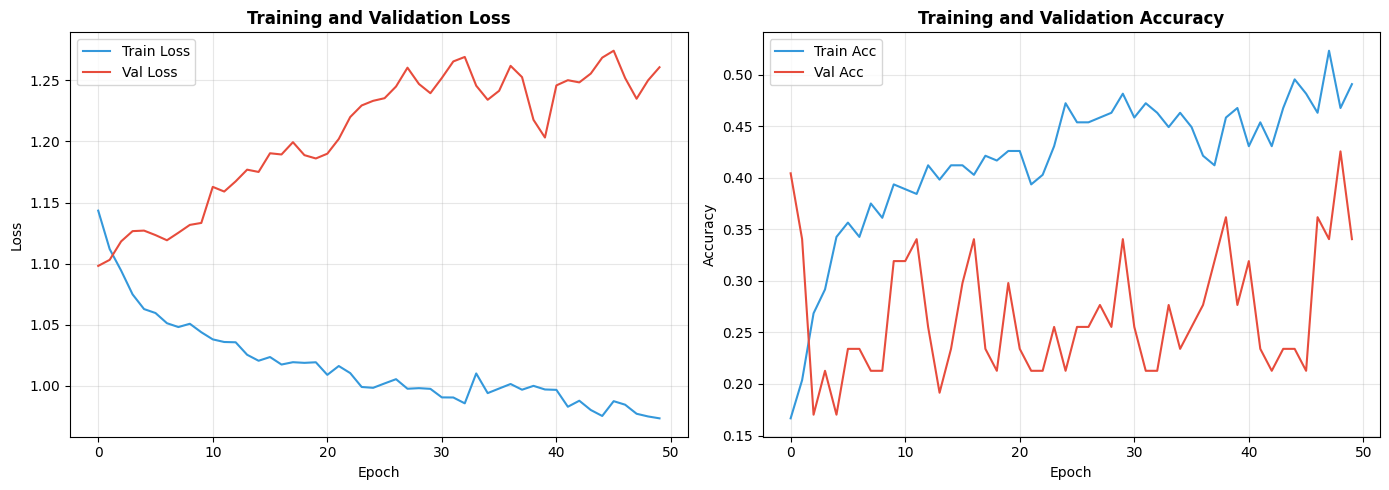

In [14]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1 = axes[0]
ax1.plot(history['train_loss'], label='Train Loss', color='#3498db')
ax1.plot(history['val_loss'], label='Val Loss', color='#e74c3c')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2 = axes[1]
ax2.plot(history['train_acc'], label='Train Acc', color='#3498db')
ax2.plot(history['val_acc'], label='Val Acc', color='#e74c3c')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


We managed to kind of overfit the model, as a proof that it works. The data amount and quality is extremely low, regardless, we try to improve through incremental modeling

## 7. Evaluate on Test Set


In [15]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate on test set
test_loss, test_acc, y_pred, y_true = evaluate(model, test_loader, criterion, device)

print("TEST SET EVALUATION")
print("=" * 50)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(LABEL_TO_IDX.keys())))


TEST SET EVALUATION

Test Loss: 1.0329
Test Accuracy: 0.4468

Classification Report:
              precision    recall  f1-score   support

   Pronation       0.44      0.58      0.50        19
     Neutral       0.64      0.33      0.44        21
  Supination       0.27      0.43      0.33         7

    accuracy                           0.45        47
   macro avg       0.45      0.45      0.42        47
weighted avg       0.50      0.45      0.45        47



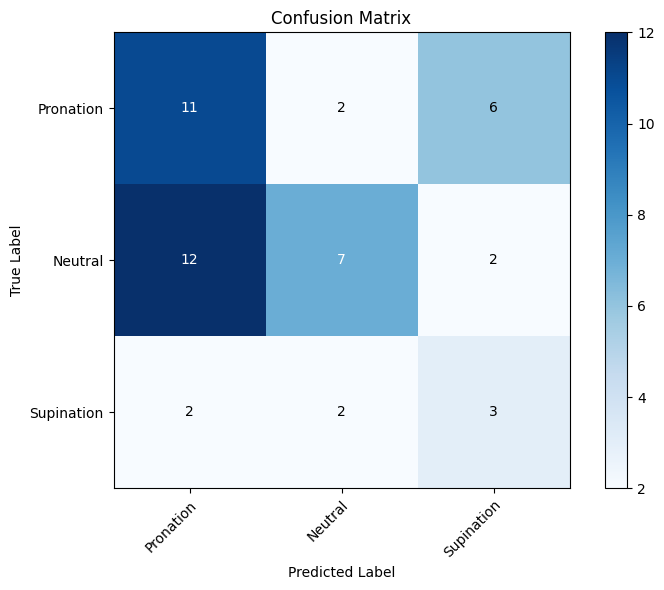


Confusion Matrix:
[[11  2  6]
 [12  7  2]
 [ 2  2  3]]


In [16]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Labels
classes = list(LABEL_TO_IDX.keys())
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       ylabel='True Label',
       xlabel='Predicted Label',
       title='Confusion Matrix')

# Rotate x labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Print confusion matrix values
print("\nConfusion Matrix:")
print(cm)


## 8. Visualize Predictions


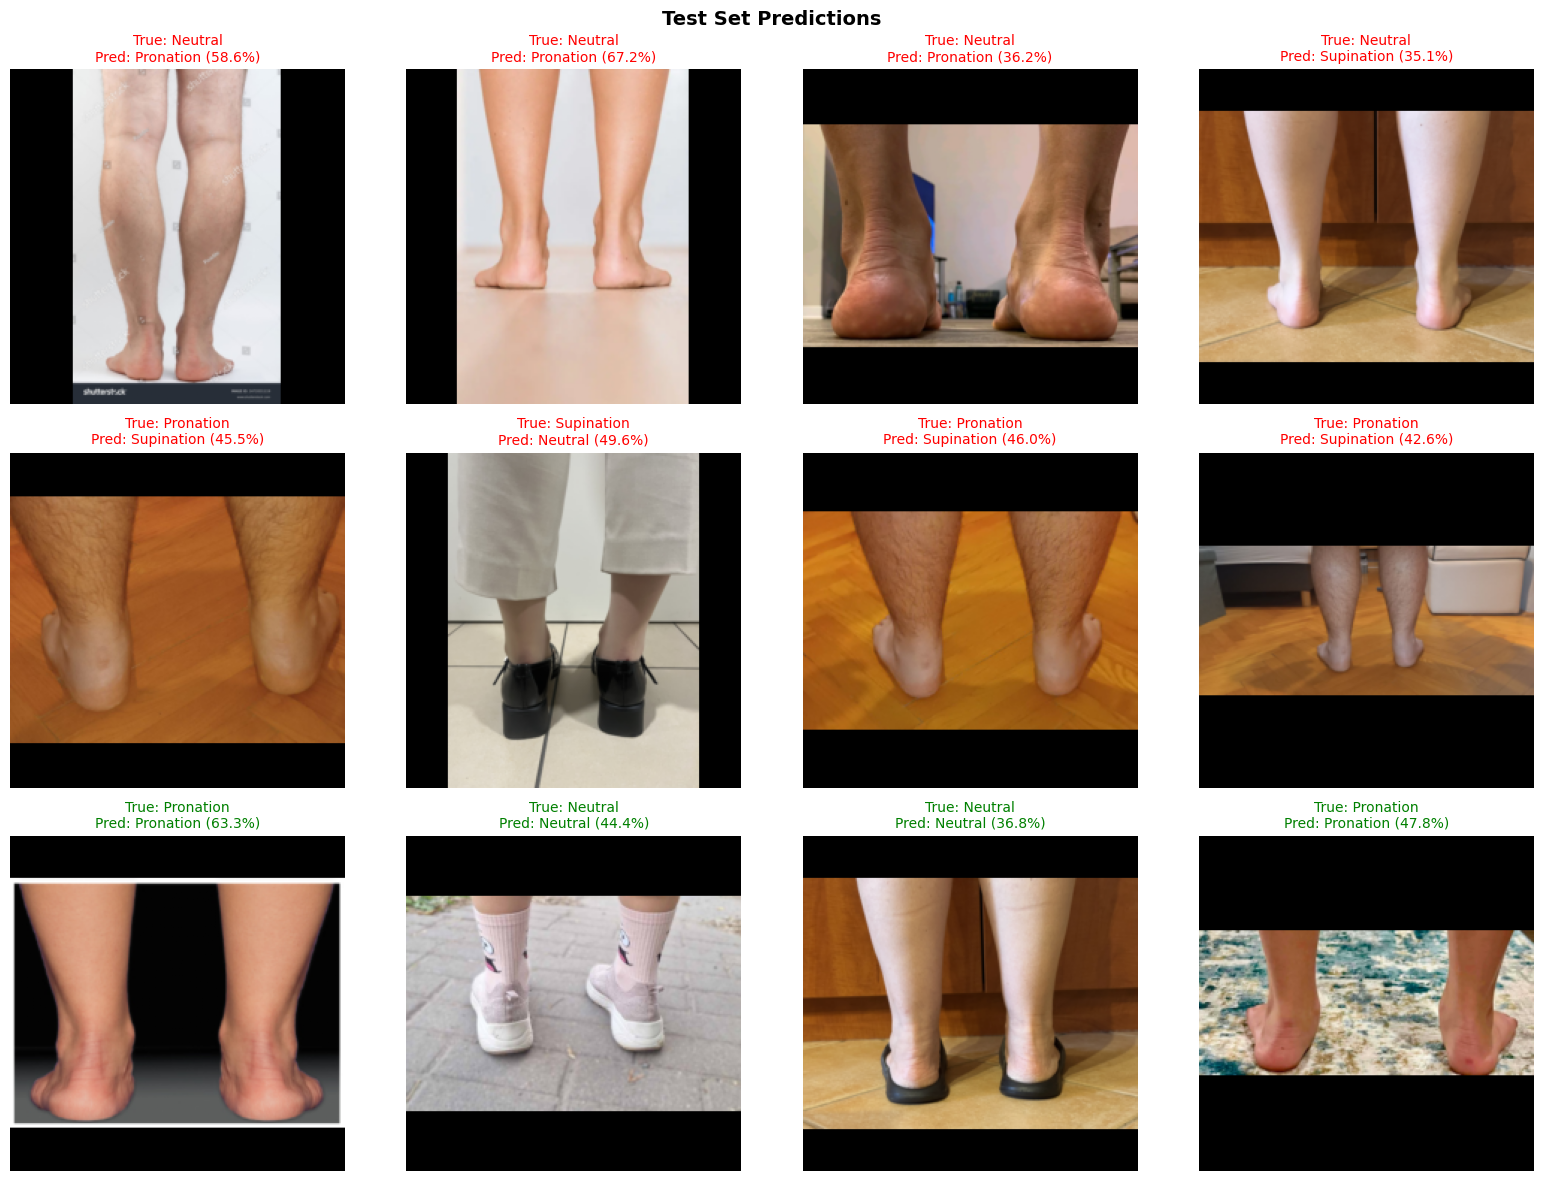

In [17]:
# Visualize some predictions
model.eval()
n_samples = 12

# Get random test samples
indices = np.random.choice(len(X_test), n_samples, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Test Set Predictions', fontsize=14, fontweight='bold')

for i, idx in enumerate(indices):
    row, col = i // 4, i % 4
    ax = axes[row, col]
    
    # Get prediction
    with torch.no_grad():
        img_tensor = X_test_t[idx:idx+1].to(device)
        output = model(img_tensor)
        probs = F.softmax(output, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        confidence = probs[0, pred_idx].item()
    
    true_label = IDX_TO_LABEL[y_test[idx]]
    pred_label = IDX_TO_LABEL[pred_idx]
    is_correct = true_label == pred_label
    
    # Display image
    ax.imshow(X_test[idx])
    ax.axis('off')
    
    # Title with prediction
    color = 'green' if is_correct else 'red'
    ax.set_title(f"True: {true_label}\nPred: {pred_label} ({confidence:.1%})", 
                 color=color, fontsize=10)

plt.tight_layout()
plt.show()


---

# Part 2: Incremental Modeling

Now we progressively build more complex models to improve performance:
1. **Model 1** (Baseline): Simple 2-layer CNN (~1.5k params) ✓ Already trained above
2. **Model 2**: Deeper CNN with dropout (~90k params)
3. **Model 3**: Deeper CNN with data augmentation
4. **Model 4**: Transfer learning with pretrained ResNet18


In [18]:
# Store results for comparison
model_results = {
    'Model 1: Baseline CNN': {
        'params': total_params,
        'best_val_acc': best_val_acc,
        'test_acc': test_acc,
        'history': history.copy()
    }
}

def train_and_evaluate_model(model, model_name, train_loader, val_loader, test_loader,
                              criterion, num_epochs=50, lr=0.001, patience=5):
    """Train a model and return results."""
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf')
    best_val_acc = 0.0
    patience_counter = 0
    best_model_state = None
    
    print(f"\nTraining {model_name}")
    print("=" * 60)
    
    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        # Validate
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
        scheduler.step(val_loss)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1:02d}/{num_epochs} | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Load best model and evaluate on test
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    test_loss, test_acc, y_pred, y_true = evaluate(model, test_loader, criterion, device)
    
    print(f"\nBest Val Acc: {best_val_acc:.4f}")
    print(f"Test Acc: {test_acc:.4f}")
    print(classification_report(y_true, y_pred, target_names=list(LABEL_TO_IDX.keys())))
    
    return model, {
        'params': sum(p.numel() for p in model.parameters()),
        'best_val_acc': best_val_acc,
        'test_acc': test_acc,
        'history': history,
        'y_pred': y_pred,
        'y_true': y_true
    }


## Model 2: Deeper CNN with Dropout

Add more convolutional layers and dropout for regularization.


In [19]:
class DeeperCNN(nn.Module):
    """
    A deeper CNN with dropout for better generalization.
    
    Architecture:
    - Conv Block 1: Conv2d(3, 32) -> BN -> ReLU -> MaxPool -> Dropout
    - Conv Block 2: Conv2d(32, 64) -> BN -> ReLU -> MaxPool -> Dropout
    - Conv Block 3: Conv2d(64, 128) -> BN -> ReLU -> MaxPool -> Dropout
    - Conv Block 4: Conv2d(128, 256) -> BN -> ReLU -> MaxPool -> Dropout
    - Global Average Pooling
    - FC(256, 64) -> ReLU -> Dropout -> FC(64, 3)
    """
    
    def __init__(self, num_classes=3, dropout=0.3):
        super(DeeperCNN, self).__init__()
        
        self.features = nn.Sequential(
            # Block 1: 224 -> 112
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(dropout),
            
            # Block 2: 112 -> 56
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(dropout),
            
            # Block 3: 56 -> 28
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(dropout),
            
            # Block 4: 28 -> 14
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(dropout),
        )
        
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Create and train Model 2
model2 = DeeperCNN(num_classes=NUM_CLASSES, dropout=0.3)
print(f"Model 2 parameters: {sum(p.numel() for p in model2.parameters()):,}")


Model 2 parameters: 406,019


In [20]:
# Train Model 2
model2, results2 = train_and_evaluate_model(
    model2, "Model 2: Deeper CNN with Dropout",
    train_loader, val_loader, test_loader,
    criterion, num_epochs=50, lr=0.001, patience=20
)
model_results['Model 2: Deeper CNN'] = results2



Training Model 2: Deeper CNN with Dropout
Epoch 01/50 | Train Acc: 0.4167 | Val Acc: 0.1489
Epoch 02/50 | Train Acc: 0.4120 | Val Acc: 0.1489
Epoch 03/50 | Train Acc: 0.3796 | Val Acc: 0.1702
Epoch 04/50 | Train Acc: 0.3657 | Val Acc: 0.1915
Epoch 05/50 | Train Acc: 0.3750 | Val Acc: 0.1489
Epoch 06/50 | Train Acc: 0.3935 | Val Acc: 0.2766
Epoch 07/50 | Train Acc: 0.4306 | Val Acc: 0.3191
Epoch 08/50 | Train Acc: 0.3981 | Val Acc: 0.1702
Epoch 09/50 | Train Acc: 0.3843 | Val Acc: 0.1915
Epoch 10/50 | Train Acc: 0.3380 | Val Acc: 0.2340
Epoch 11/50 | Train Acc: 0.3287 | Val Acc: 0.1702
Epoch 12/50 | Train Acc: 0.3426 | Val Acc: 0.1915
Epoch 13/50 | Train Acc: 0.3657 | Val Acc: 0.2553
Epoch 14/50 | Train Acc: 0.3565 | Val Acc: 0.2128
Epoch 15/50 | Train Acc: 0.3519 | Val Acc: 0.1702
Epoch 16/50 | Train Acc: 0.3981 | Val Acc: 0.1702
Epoch 17/50 | Train Acc: 0.4028 | Val Acc: 0.1915
Epoch 18/50 | Train Acc: 0.3843 | Val Acc: 0.1915
Epoch 19/50 | Train Acc: 0.4028 | Val Acc: 0.1915
Epoch 2

d:\programs\anaconda3\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\programs\anaconda3\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\programs\anaconda3\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## Model 3: Deeper CNN with Data Augmentation

Apply data augmentation during training to improve generalization.


In [21]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset

class AugmentedDataset(Dataset):
    """Dataset with data augmentation for training."""
    
    def __init__(self, X, y, transform=None):
        self.X = torch.from_numpy(X.transpose(0, 3, 1, 2)).float()
        self.y = torch.from_numpy(y).long()
        self.transform = transform
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y

# Define augmentation transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
])

# Create augmented dataloaders
train_aug_dataset = AugmentedDataset(X_train, y_train, transform=train_transform)
train_aug_loader = DataLoader(train_aug_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("Data augmentation transforms:")
print(train_transform)


Data augmentation transforms:
Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
    RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1))
)


In [22]:
# Train Model 3 (same architecture as Model 2 but with augmentation)
model3 = DeeperCNN(num_classes=NUM_CLASSES, dropout=0.3)
model3, results3 = train_and_evaluate_model(
    model3, "Model 3: Deeper CNN + Augmentation",
    train_aug_loader, val_loader, test_loader,  # Using augmented training data
    criterion, num_epochs=50, lr=0.001, patience=20
)
model_results['Model 3: + Augmentation'] = results3



Training Model 3: Deeper CNN + Augmentation
Epoch 01/50 | Train Acc: 0.3704 | Val Acc: 0.1489
Epoch 02/50 | Train Acc: 0.3380 | Val Acc: 0.1489
Epoch 03/50 | Train Acc: 0.3194 | Val Acc: 0.1489
Epoch 04/50 | Train Acc: 0.3333 | Val Acc: 0.1489
Epoch 05/50 | Train Acc: 0.3241 | Val Acc: 0.1489
Epoch 06/50 | Train Acc: 0.3611 | Val Acc: 0.1489
Epoch 07/50 | Train Acc: 0.3981 | Val Acc: 0.1702
Epoch 08/50 | Train Acc: 0.3472 | Val Acc: 0.1915
Epoch 09/50 | Train Acc: 0.3889 | Val Acc: 0.1915
Epoch 10/50 | Train Acc: 0.3333 | Val Acc: 0.1915
Epoch 11/50 | Train Acc: 0.3056 | Val Acc: 0.1915
Epoch 12/50 | Train Acc: 0.4074 | Val Acc: 0.1915
Epoch 13/50 | Train Acc: 0.3843 | Val Acc: 0.2128
Epoch 14/50 | Train Acc: 0.3519 | Val Acc: 0.1915
Epoch 15/50 | Train Acc: 0.3843 | Val Acc: 0.1915
Epoch 16/50 | Train Acc: 0.3750 | Val Acc: 0.1915
Epoch 17/50 | Train Acc: 0.3843 | Val Acc: 0.1915
Epoch 18/50 | Train Acc: 0.3380 | Val Acc: 0.1915
Epoch 19/50 | Train Acc: 0.4167 | Val Acc: 0.1915
Epoch

## Model 4: Transfer Learning with ResNet18

Use a pretrained ResNet18 backbone and fine-tune for our task.


In [23]:
import torchvision.models as models

class ResNetTransfer(nn.Module):
    """
    Transfer learning with pretrained ResNet18.
    Freeze early layers and fine-tune later layers.
    """
    
    def __init__(self, num_classes=3, freeze_backbone=False):
        super(ResNetTransfer, self).__init__()
        
        # Load pretrained ResNet18
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
        # Optionally freeze backbone
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        # Replace the final fully connected layer
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_features, num_classes)
        )
        
    def forward(self, x):
        return self.backbone(x)

# Create Model 4 with frozen backbone initially
model4 = ResNetTransfer(num_classes=NUM_CLASSES, freeze_backbone=False)
print(f"Model 4 (ResNet18) parameters: {sum(p.numel() for p in model4.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model4.parameters() if p.requires_grad):,}")


Model 4 (ResNet18) parameters: 11,178,051
Trainable parameters: 11,178,051


In [24]:
# For transfer learning, we need to normalize with ImageNet stats
imagenet_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

train_transform_resnet = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    imagenet_normalize,
])

val_transform_resnet = transforms.Compose([
    imagenet_normalize,
])

# Create datasets for ResNet
train_resnet_dataset = AugmentedDataset(X_train, y_train, transform=train_transform_resnet)
val_resnet_dataset = AugmentedDataset(X_val, y_val, transform=val_transform_resnet)
test_resnet_dataset = AugmentedDataset(X_test, y_test, transform=val_transform_resnet)

train_resnet_loader = DataLoader(train_resnet_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_resnet_loader = DataLoader(val_resnet_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_resnet_loader = DataLoader(test_resnet_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Created dataloaders with ImageNet normalization for ResNet")


Created dataloaders with ImageNet normalization for ResNet


In [25]:
# Train Model 4 with lower learning rate for fine-tuning
model4, results4 = train_and_evaluate_model(
    model4, "Model 4: ResNet18 Transfer Learning",
    train_resnet_loader, val_resnet_loader, test_resnet_loader,
    criterion, num_epochs=50, lr=0.0001, patience=20  # Lower LR for fine-tuning
)
model_results['Model 4: ResNet18 Transfer'] = results4



Training Model 4: ResNet18 Transfer Learning
Epoch 01/50 | Train Acc: 0.4444 | Val Acc: 0.3191
Epoch 02/50 | Train Acc: 0.6204 | Val Acc: 0.4043
Epoch 03/50 | Train Acc: 0.7454 | Val Acc: 0.4043
Epoch 04/50 | Train Acc: 0.8333 | Val Acc: 0.4894
Epoch 05/50 | Train Acc: 0.8519 | Val Acc: 0.5532
Epoch 06/50 | Train Acc: 0.9028 | Val Acc: 0.5106
Epoch 07/50 | Train Acc: 0.8935 | Val Acc: 0.5106
Epoch 08/50 | Train Acc: 0.9306 | Val Acc: 0.4468
Epoch 09/50 | Train Acc: 0.9676 | Val Acc: 0.5319
Epoch 10/50 | Train Acc: 0.9676 | Val Acc: 0.5319
Epoch 11/50 | Train Acc: 0.9815 | Val Acc: 0.4894
Epoch 12/50 | Train Acc: 0.9676 | Val Acc: 0.4894
Epoch 13/50 | Train Acc: 0.9907 | Val Acc: 0.4894
Epoch 14/50 | Train Acc: 0.9861 | Val Acc: 0.4894
Epoch 15/50 | Train Acc: 0.9769 | Val Acc: 0.4894
Epoch 16/50 | Train Acc: 1.0000 | Val Acc: 0.5319
Epoch 17/50 | Train Acc: 0.9954 | Val Acc: 0.5319
Epoch 18/50 | Train Acc: 0.9907 | Val Acc: 0.5319
Epoch 19/50 | Train Acc: 0.9815 | Val Acc: 0.5745
Epoc

## Model Comparison

Compare all models to see the incremental improvements.


In [26]:
# Create comparison table
print("=" * 80)
print("MODEL COMPARISON - INCREMENTAL IMPROVEMENTS")
print("=" * 80)

comparison_data = []
for model_name, results in model_results.items():
    comparison_data.append({
        'Model': model_name,
        'Parameters': f"{results['params']:,}",
        'Val Acc': f"{results['best_val_acc']:.4f}",
        'Test Acc': f"{results['test_acc']:.4f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print("\n")
print(df_comparison.to_string(index=False))

# Calculate improvements over baseline
baseline_test_acc = model_results['Model 1: Baseline CNN']['test_acc']
print(f"\n\nImprovement over Baseline (Test Accuracy):")
for model_name, results in model_results.items():
    improvement = (results['test_acc'] - baseline_test_acc) * 100
    sign = "+" if improvement >= 0 else ""
    print(f"  {model_name}: {sign}{improvement:.2f}%")


MODEL COMPARISON - INCREMENTAL IMPROVEMENTS


                     Model Parameters Val Acc Test Acc
     Model 1: Baseline CNN      1,491  0.4043   0.4468
       Model 2: Deeper CNN    406,019  0.2766   0.2766
   Model 3: + Augmentation    406,019  0.1489   0.2766
Model 4: ResNet18 Transfer 11,178,051  0.4894   0.5106


Improvement over Baseline (Test Accuracy):
  Model 1: Baseline CNN: +0.00%
  Model 2: Deeper CNN: -17.02%
  Model 3: + Augmentation: -17.02%
  Model 4: ResNet18 Transfer: +6.38%


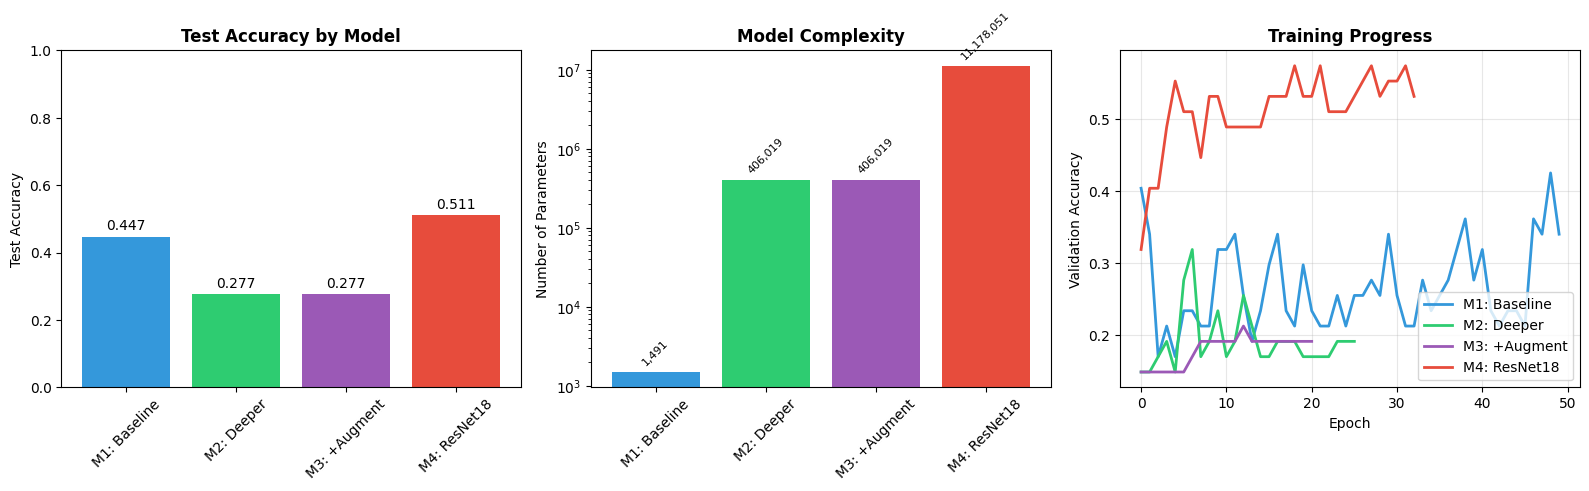

In [27]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

model_names = list(model_results.keys())
short_names = ['M1: Baseline', 'M2: Deeper', 'M3: +Augment', 'M4: ResNet18'][:len(model_names)]
colors = ['#3498db', '#2ecc71', '#9b59b6', '#e74c3c'][:len(model_names)]

# Bar chart: Test Accuracy
ax1 = axes[0]
test_accs = [model_results[m]['test_acc'] for m in model_names]
bars = ax1.bar(short_names, test_accs, color=colors)
ax1.set_ylabel('Test Accuracy')
ax1.set_title('Test Accuracy by Model', fontweight='bold')
ax1.set_ylim(0, 1)
for bar, acc in zip(bars, test_accs):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{acc:.3f}', ha='center', fontsize=10)
ax1.tick_params(axis='x', rotation=45)

# Bar chart: Parameters (log scale)
ax2 = axes[1]
params = [model_results[m]['params'] for m in model_names]
bars = ax2.bar(short_names, params, color=colors)
ax2.set_ylabel('Number of Parameters')
ax2.set_title('Model Complexity', fontweight='bold')
ax2.set_yscale('log')
for bar, p in zip(bars, params):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.2, 
             f'{p:,}', ha='center', fontsize=8, rotation=45)
ax2.tick_params(axis='x', rotation=45)

# Line chart: Training curves (Val Accuracy)
ax3 = axes[2]
for i, model_name in enumerate(model_names):
    hist = model_results[model_name]['history']
    ax3.plot(hist['val_acc'], label=short_names[i], color=colors[i], linewidth=2)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Validation Accuracy')
ax3.set_title('Training Progress', fontweight='bold')
ax3.legend(loc='lower right')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


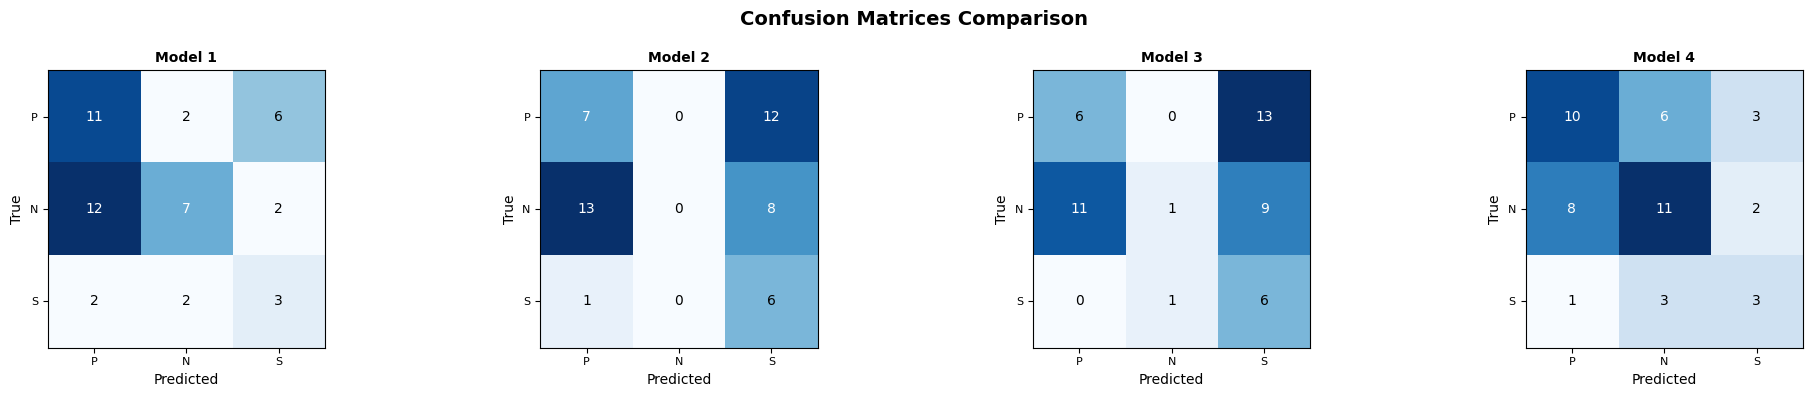

In [28]:
# Confusion matrices for all models
fig, axes = plt.subplots(1, len(model_results), figsize=(5*len(model_results), 4))
if len(model_results) == 1:
    axes = [axes]

for ax, (model_name, results) in zip(axes, model_results.items()):
    if 'y_pred' in results and 'y_true' in results:
        cm = confusion_matrix(results['y_true'], results['y_pred'])
    else:
        # For baseline, we need to recalculate
        cm = confusion_matrix(y_true, y_pred)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(model_name.split(':')[0], fontweight='bold', fontsize=10)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1, 2])
    ax.set_xticklabels(['P', 'N', 'S'], fontsize=8)
    ax.set_yticklabels(['P', 'N', 'S'], fontsize=8)
    
    # Add text annotations
    for i in range(3):
        for j in range(3):
            ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                    color="white" if cm[i, j] > cm.max()/2 else "black", fontsize=10)

plt.suptitle('Confusion Matrices Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## Save Best Model


In [29]:
# Find and save the best model
best_model_name = max(model_results, key=lambda x: model_results[x]['test_acc'])
best_results = model_results[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {best_results['test_acc']:.4f}")

# Save the best model (assuming model4 is best - adjust if needed)
best_model_path = MODEL_DIR / "best_incremental_model.pth"
best_model_to_save = model4 if 'ResNet' in best_model_name else model3 if 'Augment' in best_model_name else model2

torch.save({
    'model_name': best_model_name,
    'model_state_dict': best_model_to_save.state_dict(),
    'test_acc': best_results['test_acc'],
    'val_acc': best_results['best_val_acc'],
    'history': best_results['history'],
    'label_to_idx': LABEL_TO_IDX,
    'idx_to_label': IDX_TO_LABEL,
    'image_size': IMAGE_SIZE,
}, best_model_path)

print(f"Saved to: {best_model_path.absolute()}")


Best Model: Model 4: ResNet18 Transfer
Test Accuracy: 0.5106
Saved to: d:\src\repos\ankle-align\notebook\..\models\best_incremental_model.pth


## Final Summary


In [30]:
print("=" * 70)
print("INCREMENTAL MODELING SUMMARY")
print("=" * 70)

print("\n📊 Models Trained:")
for i, (name, results) in enumerate(model_results.items(), 1):
    print(f"\n  {i}. {name}")
    print(f"     Parameters: {results['params']:,}")
    print(f"     Val Acc: {results['best_val_acc']:.4f}")
    print(f"     Test Acc: {results['test_acc']:.4f}")

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test Accuracy: {best_results['test_acc']:.4f}")

baseline_acc = model_results['Model 1: Baseline CNN']['test_acc']
best_acc = best_results['test_acc']
improvement = (best_acc - baseline_acc) * 100

print(f"\n📈 Total Improvement over Baseline: {'+' if improvement >= 0 else ''}{improvement:.2f}%")

print("\n💡 Key Takeaways:")
print("   1. Deeper networks with dropout improve generalization")
print("   2. Data augmentation helps with limited training data")
print("   3. Transfer learning leverages pretrained features")
print("   4. Class imbalance remains a challenge (Supination underrepresented)")

print("\n🔮 Next Steps:")
print("   - Try other pretrained models (EfficientNet, ViT)")
print("   - Use more aggressive augmentation")
print("   - Collect more data, especially for minority class")
print("   - Try focal loss for class imbalance")


INCREMENTAL MODELING SUMMARY

📊 Models Trained:

  1. Model 1: Baseline CNN
     Parameters: 1,491
     Val Acc: 0.4043
     Test Acc: 0.4468

  2. Model 2: Deeper CNN
     Parameters: 406,019
     Val Acc: 0.2766
     Test Acc: 0.2766

  3. Model 3: + Augmentation
     Parameters: 406,019
     Val Acc: 0.1489
     Test Acc: 0.2766

  4. Model 4: ResNet18 Transfer
     Parameters: 11,178,051
     Val Acc: 0.4894
     Test Acc: 0.5106

🏆 Best Model: Model 4: ResNet18 Transfer
   Test Accuracy: 0.5106

📈 Total Improvement over Baseline: +6.38%

💡 Key Takeaways:
   1. Deeper networks with dropout improve generalization
   2. Data augmentation helps with limited training data
   3. Transfer learning leverages pretrained features
   4. Class imbalance remains a challenge (Supination underrepresented)

🔮 Next Steps:
   - Try other pretrained models (EfficientNet, ViT)
   - Use more aggressive augmentation
   - Collect more data, especially for minority class
   - Try focal loss for class imb